## Assignment: $k$ Means Clustering

## **Do two questions.**

`! git clone https://www.github.com/DS3001/kmc`

In [1]:
! git clone https://www.github.com/DS3001/kmc

Cloning into 'kmc'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 25 (delta 2), reused 1 (delta 1), pack-reused 21
Receiving objects: 100% (25/25), 5.04 MiB | 11.40 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **Q1.**
This question is a case study for $k$ means clustering.


1. Load the `airbnb_hw.csv` data. Clean `Price` along with `Beds`, `Number of Reviews`, and `Review Scores Rating`.
2. Maxmin normalize the data and remove any `nan`'s (`KMeans` from `sklearn` doesn't accept `nan` input).
3. Use `sklearn`'s `KMeans` module to cluster the data by `Beds`, `Number of Reviews`, and `Review Scores Rating` for `k=6`.
4. Use `seaborn`'s `.pairplot()` to make a grid of scatterplots that show how the clustering is carried out in multiple dimensions.
5. Use `.groupby` and `.describe` to compute the average price for each cluster. Which clusters have the highest rental prices?
6. Use a scree plot to pick the number of clusters and repeat steps 4 and 5.

## PT 1

In [42]:
# load airbnb data

df = pd.read_csv('/content/kmc/data/airbnb_hw.csv', low_memory=False)

In [43]:
# clean price

df['Price'] = df['Price'].str.replace(',','')  # take out commas
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')  # coerce to numeric

In [44]:
# clean beds

df['Beds'] = pd.to_numeric(df['Beds'], errors='coerce')  # coerce to numeric

In [45]:
# clean number of reviews

df['Number Of Reviews'].dtype
df['Number Of Reviews'].value_counts()
# Number of Reviews is already an int so we don't need to transform it

0      7814
1      3572
2      2457
3      1764
4      1382
       ... 
216       1
191       1
213       1
178       1
130       1
Name: Number Of Reviews, Length: 205, dtype: int64

In [46]:
# clean review scores rating

df['Review Scores Rating'].dtype
df['Review Scores Rating'].isnull().sum() # there are 8323 nan

df.loc[df['Number Of Reviews']==0,'Review Scores Rating'].isnull().sum() # 7814 nan are because the listings have no reviews yet
df.loc[df['Number Of Reviews']>0,'Review Scores Rating'].isnull().sum() # there are 509 nan that do have reviews, these are actually missing
# Review scores rating is already a float

509

## PT 2

In [47]:
# set my_df = relevant variables
my_df = df.loc[:,['Price','Beds','Number Of Reviews','Review Scores Rating']]

# remove null
my_df = my_df.dropna()

# select clustering variables
X = my_df.loc[:,['Beds','Number Of Reviews','Review Scores Rating']]
y = my_df['Price']

# maxmin normalize
def maxmin(x):
    z = (x-min(x))/(max(x)-min(x))
    return z

X = X.apply(maxmin)

## PT 3

In [48]:
from sklearn.cluster import KMeans

# model and cluster
initial_centroids = np.random.randint(low=1,high=24,size=6) # Determine initial centroids
model = KMeans(n_clusters=6, max_iter=1, init = X.iloc[initial_centroids,:],  random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
X['cluster'] = model.predict(X) # Predict values

centers = model.cluster_centers_ # Get the computed centers for the kmc model

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


## PT 4

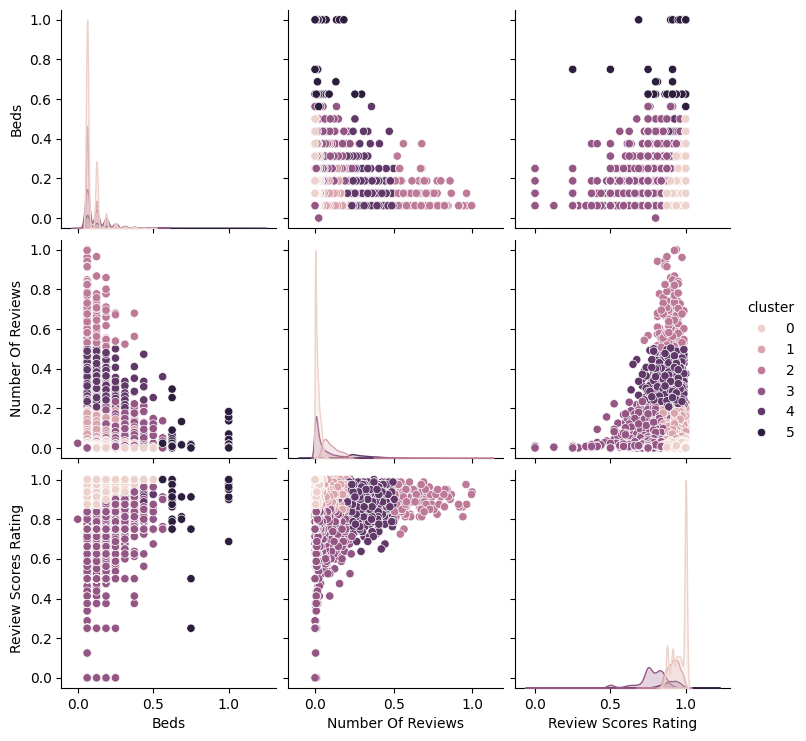

In [26]:
sns.pairplot(X, hue='cluster')

## PT 5

In [49]:
# compute avg price for each cluster

my_df['cluster'] = X['cluster'] # add cluster column back with not normalized data
my_df.groupby('cluster')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,5050.0,139.828119,123.032901,20.0,75.00,115.0,175.0,5000.0
1,2547.0,156.175893,107.934789,22.0,90.00,130.0,190.0,1500.0
2,8313.0,163.039456,147.800971,10.0,89.00,135.0,199.0,4500.0
3,4622.0,157.587192,183.874409,25.0,87.00,130.0,190.0,10000.0
4,1544.0,137.740933,85.068324,27.0,84.75,120.0,172.5,875.0
5,35.0,641.571429,851.789786,95.0,252.00,350.0,762.5,5000.0


Cluster 5 has the highest average price by far at \$641.57, the other clusters are all between approximately \$130 to \$165.

## PT 6

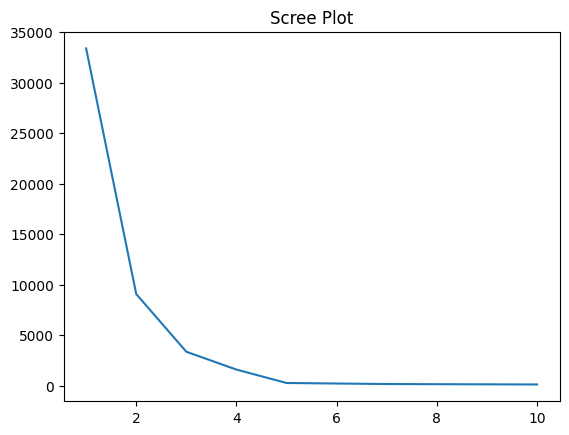

In [52]:
k_bar = 10
k_grid = np.arange(1,k_bar+1) # The range of k's to consider
SSE = np.zeros(k_bar) # We'll store the training error here
for k in range(k_bar): # For indices from 0 to k_bar-1
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0) # Create a model for k
    model = model.fit(X) # Fit the emodel
    SSE[k] = model.inertia_ # Record the sum of squared error for k in the SSE vector

scree_plot = sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot') # Create scree plot

# **Q2.**


This is a question about $k$ means clustering. We want to investigate how adjusting the "noisiness" of the data impacts the quality of the algorithm and the difficulty of picking $k$.

1. Run the code below, which creates four datasets: `df0_125`, `df0_25`, `df0_5`, `df1_0`, and `df2_0`. Each data set is created by increasing the amount of `noise` (standard deviation) around the cluster centers, from `0.125` to `0.25` to `0.5` to `1.0` to `2.0`.

```
import numpy as np
import pandas as pd

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)
```

2. Make scatterplots of the $(X1,X2)$ points by group for each of the datasets. As the `noise` goes up from 0.125 to 2.0, what happens to the visual distinctness of the clusters?
3. Create a scree plot for each of the datasets. Describe how the level of `noise` affects the scree plot (particularly the presence of a clear "elbow") and your ability to definitively select a $k$.
4. Explain the intuition of the elbow, using this numerical simulation as an example.

## PT 1

In [12]:
def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)

## PT 2

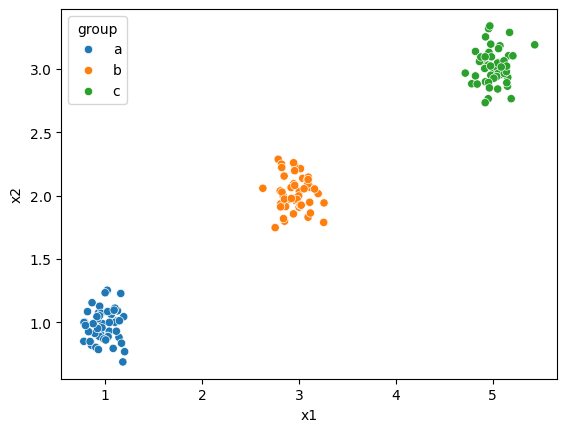

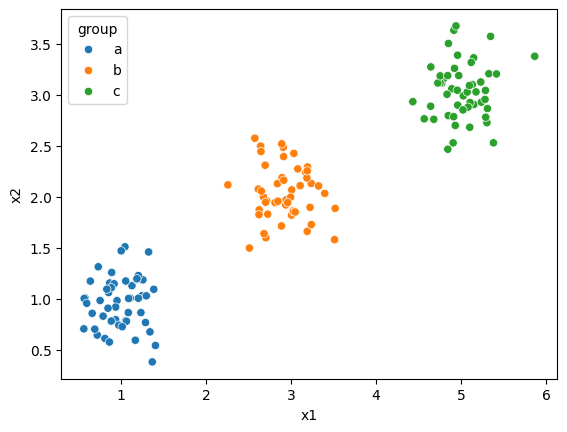

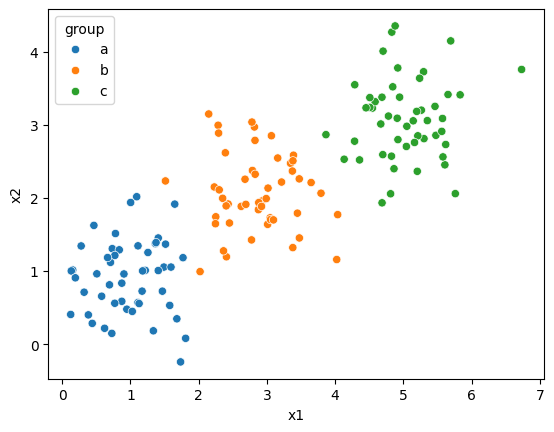

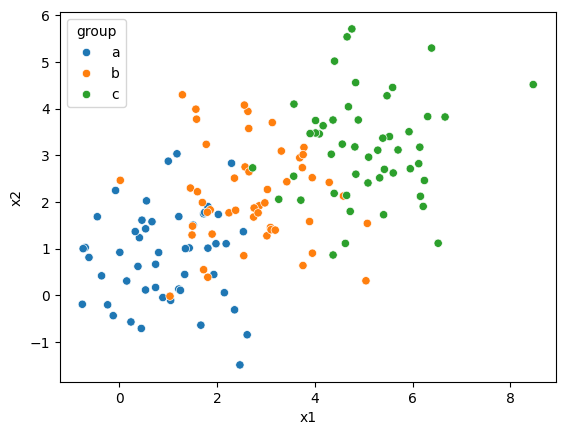

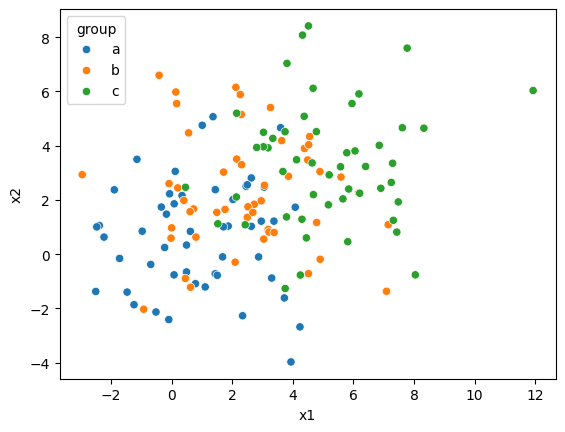

In [23]:
df_list = [df0_125, df0_25, df0_5, df1_0, df2_0]

for df in df_list:
  sns.scatterplot(data=df,x='x1',y='x2',hue='group')
  plt.show()

# **Q3.**

We looked at computer vision with $k$NN in a previous question. Can $k$ means clustering correctly group digits, even if we don't know which symbols are which?

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use $k$ means clustering on the reshaped `X_test` data with `k=10`.  
5. Cross tabulate the cluster assignments with the true labels for the test set values. How good is the correspondence? What proportion of digits are clustered correctly? Which digits are the hardest to distinguish from one another? Can $k$MC recover the latent digits 0 to 9, without even knowing what those digits were?
6. If you use a scree plot to determine the number of clusters $k$, does it pick 10 (the true number of digits), or not? If it fails to pick $k=10$, which digits does it tend to combine into the same classification?